# 1_emulator
notebook for loading in a trained emulator, incuding the .json file with custom_object variables and data scaling values.\
Emulator .model and .json are stored in files in the repo.

In [1]:
#### misc
import pandas as pd
import numpy as np
import os
from pathlib import Path
import pickle
import time
from itertools import product
from scipy import constants
from scipy import stats
import random
import astropy.constants
from numpy.random import default_rng
import pickle

#### graphical
import matplotlib.pyplot as plt

#### ML
from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator
import sklearn
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
from keras import layers

##### poke gpu
os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

print("Current GPU usage:\n"
     + " - GPU0: " + str(gpu0usage) + "B\n")

2024-04-24 13:38:39.053034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 13:38:39.053063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 13:38:39.053863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 13:38:39.058361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 13:38:39.607203: W tensorflow/compiler/tf2

Current GPU usage:
 - GPU0: 0B



2024-04-24 13:38:40.194694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18190 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6


# 1) Specify emulator name
if file structure has been organised properly, just the name should find the emulator and unpack the relevant .json and .model files

In [3]:
pitchfork_name = "nu6-40"

# 2) Unpickle emulator dict
Unpack .json, print architecture and emulator parameter ranges

In [4]:
file_path = "pickle jar/"+pitchfork_name

with open(file_path+".pkl", 'rb') as fp:
     emulator_dict = pickle.load(fp)

# 3) Load in emulator with custom objects
Loading in the emulator from keras .model file using custom objects from dict

In [5]:
custom_objects = {"InversePCA": InversePCA(emulator_dict['custom_objects']['inverse_pca']['pca_comps'], emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(emulator_dict['custom_objects']['WMSE']['weights'])}

model = tf.keras.models.load_model(file_path+".h5", custom_objects=custom_objects)

# 4) print emulator parameter ranges
use the saved ranges from the pickled dict to print out reasonable parameter ranges for network to query

In [6]:
[print(str(key).replace("log_","") + " range: " + "[min = " + str(emulator_dict['parameter_ranges'][key]["min"]) + ", max = " + str(emulator_dict['parameter_ranges'][key]["max"]) + "]") for key in emulator_dict['parameter_ranges'].keys()]; 

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


# 5) test predictions
Nice!

In [7]:
model(np.array([[0, 0, 0, 0, 0]]))

2024-03-20 14:00:25.710960: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-20 14:00:25.766602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


[<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.4059231, -0.1889165, -0.0265745]], dtype=float32)>,
 <tf.Tensor: shape=(1, 35), dtype=float32, numpy=
 array([[0.43196377, 0.4347581 , 0.43773463, 0.43961442, 0.4397998 ,
         0.43835348, 0.43669775, 0.43626782, 0.43661922, 0.43650085,
         0.43560123, 0.43461916, 0.43424672, 0.4344684 , 0.43484232,
         0.4350686 , 0.4350985 , 0.43507016, 0.43509513, 0.43519545,
         0.4354824 , 0.43614548, 0.437058  , 0.4378288 , 0.43826604,
         0.4385652 , 0.4389439 , 0.43932095, 0.43933064, 0.43855643,
         0.4368676 , 0.43458012, 0.43230602, 0.43061897, 0.4298179 ]],
       dtype=float32)>]

# 6) Rescale using pickled parameters

In [9]:
class emulator:
    def __init__(self, emulator_name):
        self.emulator_name = emulator_name
        self.file_path = "pickle jar/"+ self.emulator_name

        with open(self.file_path+".pkl", 'rb') as fp:
             self.emulator_dict = pickle.load(fp)
            
        self.custom_objects = {"InversePCA": InversePCA(self.emulator_dict['custom_objects']['inverse_pca']['pca_comps'], self.emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(self.emulator_dict['custom_objects']['WMSE']['weights'])}

        self.model = tf.keras.models.load_model(self.file_path+".h5", custom_objects=custom_objects)

        [print(str(key).replace("log_","") + " range: " + "[min = " + str(self.emulator_dict['parameter_ranges'][key]["min"]) + ", max = " + str(self.emulator_dict['parameter_ranges'][key]["max"]) + "]") for key in self.emulator_dict['parameter_ranges'].keys()];

    def predict(self, input_data,verbose=False):
        log_inputs_mean = np.array(self.emulator_dict["data_scaling"]["inp_mean"][0])
        
        log_inputs_std = np.array(self.emulator_dict["data_scaling"]["inp_std"][0])

        log_outputs_mean = np.array(self.emulator_dict["data_scaling"]["classical_out_mean"][0] + self.emulator_dict["data_scaling"]["astero_out_mean"][0])
        
        log_outputs_std = np.array(self.emulator_dict["data_scaling"]["classical_out_std"][0] + self.emulator_dict["data_scaling"]["astero_out_std"][0])
        
        log_inputs = np.log10(input_data)
        
        standardised_log_inputs = (log_inputs - log_inputs_mean)/log_inputs_std

        standardised_log_outputs = self.model.predict(standardised_log_inputs, verbose=verbose)

        standardised_log_outputs = np.concatenate((np.array(standardised_log_outputs[0]),np.array(standardised_log_outputs[1])), axis=1)

        log_outputs = (standardised_log_outputs*log_outputs_std) + log_outputs_mean

        outputs = 10**log_outputs

        return outputs

In [10]:
pitchfork = emulator("nu6-40")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [11]:
pitchfork.predict(np.array([[1, 0.2, 0.3, 2, 8]]))

array([[1.34286002e+00, 1.52817385e+00, 6.77941480e-02, 3.48856600e+02,
        3.93594907e+02, 4.35992832e+02, 4.82244537e+02, 5.30866788e+02,
        5.77488251e+02, 6.22042342e+02, 6.67088072e+02, 7.13487222e+02,
        7.60516769e+02, 8.07659381e+02, 8.54908502e+02, 9.02329602e+02,
        9.49782338e+02, 9.97018083e+02, 1.04386924e+03, 1.09000968e+03,
        1.13529594e+03, 1.17962368e+03, 1.22246570e+03, 1.26360286e+03,
        1.30400624e+03, 1.34541641e+03, 1.38898617e+03, 1.43475826e+03,
        1.48205131e+03, 1.52990752e+03, 1.57772108e+03, 1.62535408e+03,
        1.67281671e+03, 1.71999240e+03, 1.76664045e+03, 1.81272295e+03,
        1.85860636e+03, 1.90473949e+03]])

# 7) Test data
Let's try with some test data from our test set (should be in h5 file)

In [12]:
df_test = pd.read_hdf('/home/oxs235/repos/ojscutt/sl-pitchfork/test_data.h5', key='df')

test_point = df_test.sample(n=1)
test_point

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
5119266,1.06,0.007903,0.3,2.5,0.127754,1.013203,1.684949,6537.743174,0.007779,668.979172,...,0.675594,0.675674,0.676826,0.678065,0.679264,0.680205,0.680478,0.679811,0.678156,0.676193


In [13]:
test_inputs = test_point[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']]

test_inputs.values

array([[1.06      , 0.00790293, 0.3       , 2.5       , 0.12775372]])

In [14]:
pitchfork.predict(test_inputs.values)

array([[1.01272450e+00, 1.68103942e+00, 7.77224826e-03, 9.52212421e+02,
        1.09294572e+03, 1.23451006e+03, 1.37557988e+03, 1.51599466e+03,
        1.65518309e+03, 1.79075931e+03, 1.92258313e+03, 2.05401032e+03,
        2.18756765e+03, 2.32239061e+03, 2.45627746e+03, 2.58862858e+03,
        2.72060959e+03, 2.85338906e+03, 2.98728272e+03, 3.12200090e+03,
        3.25698024e+03, 3.39203186e+03, 3.52723069e+03, 3.66237777e+03,
        3.79731683e+03, 3.93244375e+03, 4.06810190e+03, 4.20384681e+03,
        4.33889073e+03, 4.47305153e+03, 4.60682636e+03, 4.74059613e+03,
        4.87396407e+03, 5.00568876e+03, 5.13452560e+03, 5.26027100e+03,
        5.38408433e+03, 5.50776082e+03]])

In [15]:
test_point[['radius', 'luminosity', 'surface_Z']+[f'nu_0_{i+1}' for i in range(5,40)]].values

array([[1.01320322e+00, 1.68494943e+00, 7.77891942e-03, 9.52187837e+02,
        1.09302248e+03, 1.23426681e+03, 1.37558194e+03, 1.51596332e+03,
        1.65528469e+03, 1.79036739e+03, 1.92282799e+03, 2.05415844e+03,
        2.18759417e+03, 2.32210898e+03, 2.45631444e+03, 2.58904717e+03,
        2.72072094e+03, 2.85322049e+03, 2.98694428e+03, 3.12206823e+03,
        3.25726017e+03, 3.39250744e+03, 3.52726054e+03, 3.66201282e+03,
        3.79707743e+03, 3.93239268e+03, 4.06817788e+03, 4.20367051e+03,
        4.33895001e+03, 4.47222778e+03, 4.60686799e+03, 4.74081642e+03,
        4.87378005e+03, 5.00531332e+03, 5.13454770e+03, 5.26098005e+03,
        5.38471649e+03, 5.50773676e+03]])

In [16]:
print(pitchfork.predict(test_inputs.values)-test_point[['radius', 'luminosity', 'surface_Z']+[f'nu_0_{i+1}' for i in range(5,40)]].values)

[[-4.78718719e-04 -3.91001105e-03 -6.67115174e-06  2.45836827e-02
  -7.67566981e-02  2.43252208e-01 -2.05876520e-03  3.13357008e-02
  -1.01592745e-01  3.91915515e-01 -2.44865893e-01 -1.48118748e-01
  -2.65113791e-02  2.81623348e-01 -3.69724562e-02 -4.18596566e-01
  -1.11344366e-01  1.68573779e-01  3.38434536e-01 -6.73238316e-02
  -2.79923517e-01 -4.75583438e-01 -2.98509541e-02  3.64947540e-01
   2.39392090e-01  5.10739237e-02 -7.59797827e-02  1.76304628e-01
  -5.92820703e-02  8.23748799e-01 -4.16305773e-02 -2.20283602e-01
   1.84017110e-01  3.75446925e-01 -2.20963592e-02 -7.09049894e-01
  -6.32161852e-01  2.40537397e-02]]


In [17]:
df_test = pd.read_hdf('/home/oxs235/repos/ojscutt/sl-pitchfork/test_data.h5', key='df')

test_points = df_test.sample(n=1)

test_inputs = np.array(test_points[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values)

predictions = pitchfork.predict(test_inputs)

print(predictions-test_points[['radius', 'luminosity', 'surface_Z']+[f'nu_0_{i+1}' for i in range(5,40)]].values)

[[-1.53955326e-02  3.02031768e-02 -2.22648370e-07 -2.41768167e-01
   3.79354735e-02  7.20203048e-02  1.03341992e-01 -1.49930050e-01
   6.40161228e-02  2.25241669e-01  4.76028784e-02  8.85631768e-02
   3.42572321e-03  4.39989781e-02  9.84769308e-02 -2.03313558e-01
  -2.14457998e-01  1.28762167e-01  2.60540253e-01  4.18778852e-01
   2.46143418e-01 -8.45554010e-02  6.46081476e-02 -6.26763058e-02
  -2.03452647e-01 -1.15635559e-01 -1.33240533e-01 -1.64736960e-01
  -3.29258954e-01 -2.03465623e-01  1.81569114e-01  8.96760737e-04
  -4.55131057e-01 -4.33115003e-01 -8.40995900e-02  1.24724309e-01
  -1.35434390e-02 -2.14739147e-01]]


[[-1.21240019e-03 -3.88591284e-04 -6.86070458e-06 ...  1.87301229e+00
   3.32257716e-01 -5.90362539e-01]
 [-1.19536699e-03 -4.12551511e-04 -1.16754246e-06 ...  2.02234561e+00
   5.30782435e-01 -3.00365264e-01]
 [-1.10707821e-03 -3.21884295e-04  3.96257557e-06 ...  1.92039164e+00
   4.81226959e-01 -2.50472419e-01]
 ...
 [-1.13078274e-02 -1.22223418e-02  1.52697075e-05 ... -1.47436801e-01
  -8.84005590e-02  1.57068944e-01]
 [-1.23421565e-02 -1.45584897e-02  1.45687395e-05 ... -1.53712517e-01
  -8.58735667e-02  1.69999388e-01]
 [-1.35434913e-02 -1.72174949e-02  1.44346488e-05 ...  1.51703425e-01
   2.65074603e-01  5.63697736e-01]]


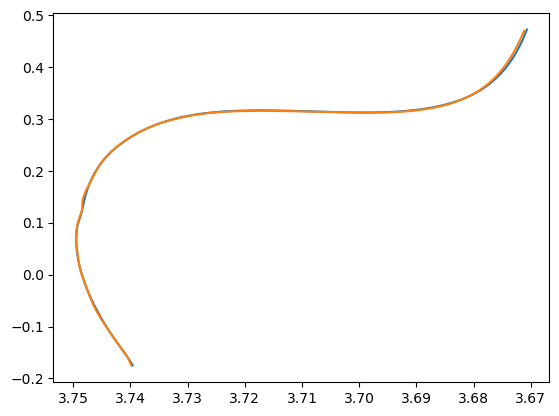

In [18]:
def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())

# extract solar track:
df_full = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df')
df_mass = df_full[df_full["initial_mass"]==1.0]

df_mass_zinit = df_mass[df_mass["initial_Zinit"] == df_mass.iloc[(df_mass['initial_Zinit']-0.014).abs().argsort()[:1]]['initial_Zinit'].tolist()[0]]
df_test = df_mass_zinit.set_index(np.arange(0,len(df_mass_zinit)))

test_inputs = np.array(df_test[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values)

predictions = pitchfork.predict(test_inputs)

print(predictions-df_test[['radius', 'luminosity', 'surface_Z']+[f'nu_0_{i+1}' for i in range(5,40)]].values)

plt.plot(np.log10(calc_Teff(df_test['luminosity'], df_test['radius'])),np.log10(df_test['luminosity']))
plt.plot(np.log10(np.array(((predictions[:,1]*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((predictions[:,0]*astropy.constants.R_sun)**2)))**0.25)),np.log10(predictions[:,1]))
plt.gca().invert_xaxis()

In [19]:
df_test = pd.read_hdf('/home/oxs235/repos/ojscutt/sl-pitchfork/test_data.h5', key='df')
df_test

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
62,0.8,0.005436,0.24,1.9,1.830644,0.734012,0.396820,5350.894460,0.005250,950.115061,...,1.455915,1.456489,1.457780,1.459687,1.462175,1.464995,1.467707,1.468723,1.470753,1.471765
81,0.8,0.005436,0.24,1.9,2.590097,0.741693,0.410267,5367.648220,0.005174,936.194939,...,1.422254,1.422858,1.424153,1.426027,1.428489,1.431149,1.433287,1.434534,1.436288,1.436969
84,0.8,0.005436,0.24,1.9,2.709777,0.742931,0.412453,5370.302004,0.005162,933.989169,...,1.416864,1.417473,1.418768,1.420637,1.423093,1.425723,1.427704,1.429056,1.430764,1.431392
94,0.8,0.005436,0.24,1.9,3.108245,0.747132,0.419881,5379.132716,0.005123,926.585950,...,1.398662,1.399290,1.400583,1.402436,1.404859,1.407386,1.408247,1.410545,1.412095,1.412541
98,0.8,0.005436,0.24,1.9,3.267434,0.748841,0.422918,5382.682766,0.005107,923.608921,...,1.391294,1.391928,1.393223,1.395067,1.397474,1.399957,1.400800,1.403049,1.404535,1.404906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8141226,1.2,0.008356,0.26,2.1,3.554510,1.618158,4.112896,6466.300029,0.008356,369.619476,...,-0.720931,-0.723980,-0.728858,-0.733526,-0.736238,-0.736958,-0.736472,-0.735313,-0.734033,-0.732827
8141264,1.2,0.008356,0.26,2.1,3.667650,1.702451,4.672071,6508.327797,0.008356,343.341898,...,-0.895334,-0.899904,-0.904568,-0.907474,-0.908225,-0.907673,-0.906482,-0.904969,-0.903527,-0.902178
8141282,1.2,0.008356,0.26,2.1,3.774330,1.748112,4.788557,6462.431294,0.008356,331.555865,...,-0.974270,-0.979266,-0.983474,-0.985388,-0.985472,-0.984538,-0.983059,-0.981513,-0.980171,-0.978957
8141338,1.2,0.008356,0.26,2.1,4.252229,2.062876,5.662514,6203.619826,0.008356,263.683964,...,-1.477917,-1.477918,-1.476475,-1.474651,-1.472634,-1.470777,-1.469152,-1.467973,-1.467163,-1.466741


In [20]:
df_test = pd.read_hdf('/home/oxs235/repos/ojscutt/sl-pitchfork/test_data.h5', key='df')
df_time_test = df_test.sample(n=1000)
df_time_test_inputs = np.array([df_time_test[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values])

In [21]:
%%time
for i in range(1000):
    pitchfork.predict(df_time_test_inputs[:,i])

CPU times: user 39.6 s, sys: 7.85 s, total: 47.5 s
Wall time: 34.5 s


In [22]:
%%time
for i in range(1000):
    model.predict(df_time_test_inputs[:,i],verbose=False)

CPU times: user 40 s, sys: 7.92 s, total: 47.9 s
Wall time: 34.8 s
